In [1]:
from random import uniform
from collections import namedtuple
import numpy as np

Angles = namedtuple('Angles', ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6'])


def get_random_angles() -> Angles:
    return Angles(*[uniform(-2 * np.pi, 2 * np.pi) for _ in range(6)])


Constraints = namedtuple('Constraints', ['velocity', 'acceleration'])

# Task 1
Calculate and plot position, velocity, and acceleration trajectories of driving your robot model from configuration $q_0$ to configuration $q_f$ in joint space

In [2]:
# some random positions and constraints

initial_position = get_random_angles()
final_position = get_random_angles()
constraints = Constraints(2, 3)

In [3]:
def sign(n: float) -> float:
    if n >= 0:
        return 1
    else:
        return -1

In [4]:
def trapezoidal_trajectory(blend_time: float, non_acceleration_time: float, initial_value: float, final_value: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    _sign = sign(final_value - initial_value)

    first_stage_distance = initial_value + _sign * constraints.acceleration * blend_time ** 2 / 2
    second_stage_distance = first_stage_distance + _sign * constraints.velocity * non_acceleration_time
    timeline = np.linspace(0, blend_time * 2 + non_acceleration_time, 200)

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: initial_value + _sign * constraints.acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + _sign * constraints.velocity * (t - blend_time),
                  lambda t: second_stage_distance + _sign * constraints.velocity * (t - blend_time - non_acceleration_time) - _sign * constraints.acceleration * (t - blend_time - non_acceleration_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: _sign * constraints.acceleration * t,
                  lambda t: _sign * constraints.velocity,
                  lambda t: _sign * constraints.velocity - _sign * constraints.acceleration * (t - blend_time - non_acceleration_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: _sign * constraints.acceleration,
                  lambda t: 0,
                  lambda t: _sign * -constraints.acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [5]:
def triangular_trajectory(initial_value: float, final_value: float):
    _sign = sign(final_value - initial_value)

    blend_time = np.sqrt(abs(final_value - initial_value) / constraints.acceleration)
    timeline = np.linspace(0, blend_time * 2, 200)

    first_stage_distance = initial_value + _sign * constraints.acceleration * blend_time ** 2 / 2

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: initial_value + _sign * constraints.acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + _sign * constraints.acceleration * blend_time * (t - blend_time) - _sign * constraints.acceleration * (t - blend_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: _sign * constraints.acceleration * t,
                  lambda t: _sign * constraints.acceleration * blend_time - _sign * constraints.acceleration * (t - blend_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: _sign * constraints.acceleration,
                  lambda t: _sign * -constraints.acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [6]:
trajectories = []
velocities = []
accelerations = []
timelines = []

for initial, final in zip(initial_position, final_position):
    delta_distance = abs(final - initial)

    blend_time = constraints.velocity / constraints.acceleration
    acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

    non_acceleration_distance = delta_distance - acceleration_distance
    non_acceleration_time = non_acceleration_distance / constraints.velocity

    if non_acceleration_time < 0:
        timeline, trajectory, velocity, acceleration = triangular_trajectory(initial, final)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_trajectory(blend_time, non_acceleration_time, initial, final)
    timelines.append(timeline)
    trajectories.append(trajectory)
    velocities.append(velocity)
    accelerations.append(acceleration)

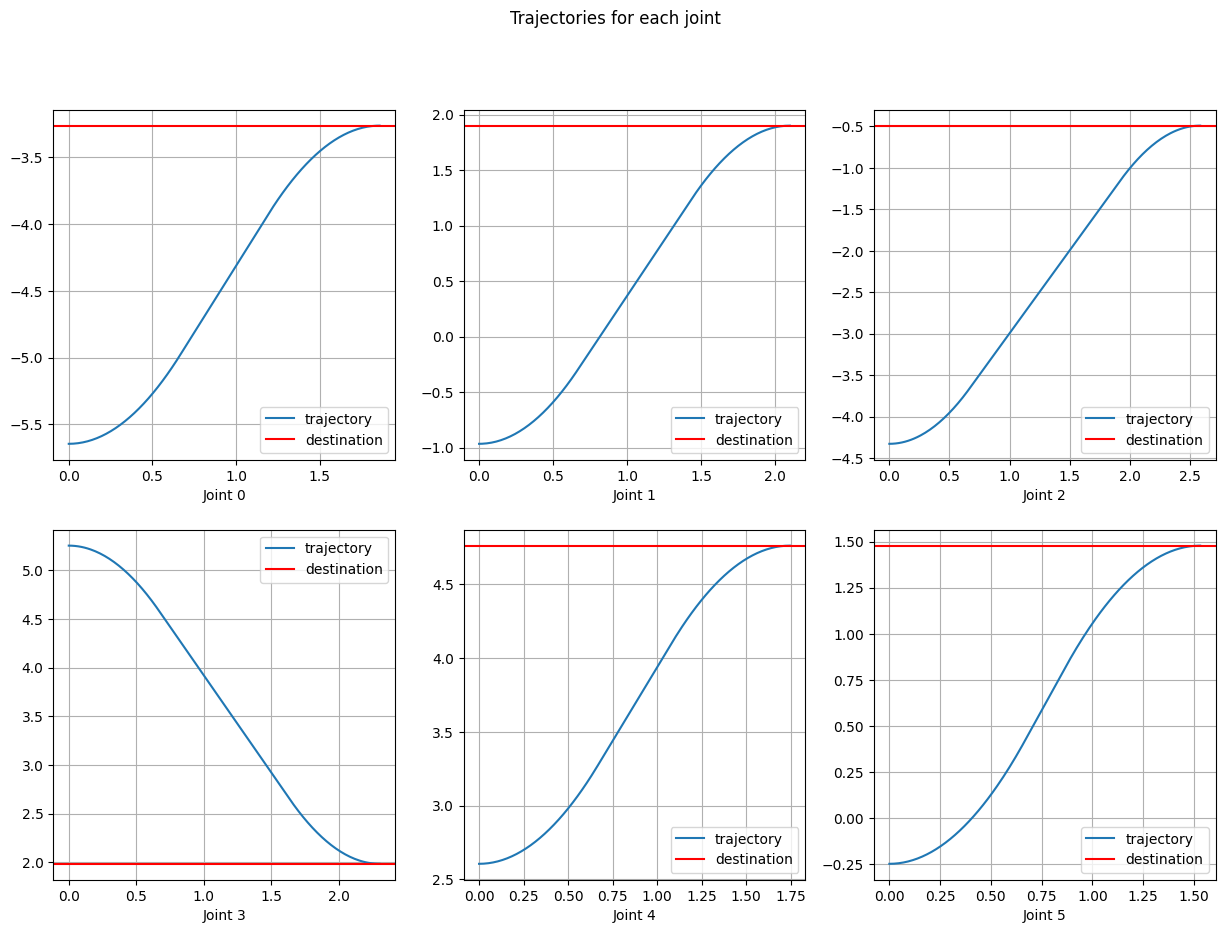

In [7]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Trajectories for each joint')

for i, (timeline, trajectory, destination) in enumerate(zip(timelines, trajectories, final_position)):
    axes[i // 3, i % 3].plot(timeline, trajectory, label='trajectory')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    axes[i // 3, i % 3].axhline(destination, label='destination', color='r')
    axes[i // 3, i % 3].legend()

plt.show()

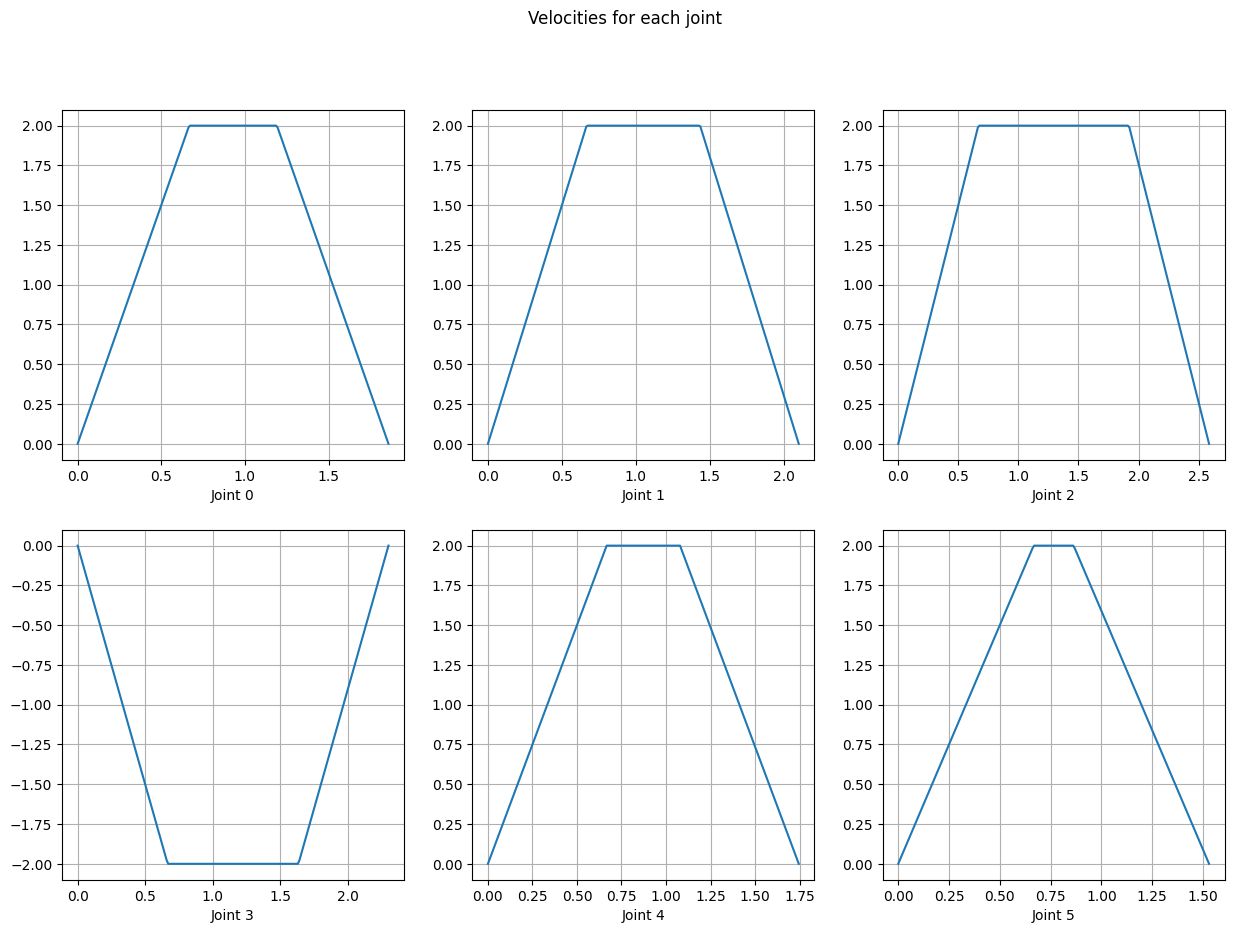

In [8]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Velocities for each joint')

for i, (timeline, velocity) in enumerate(zip(timelines, velocities)):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

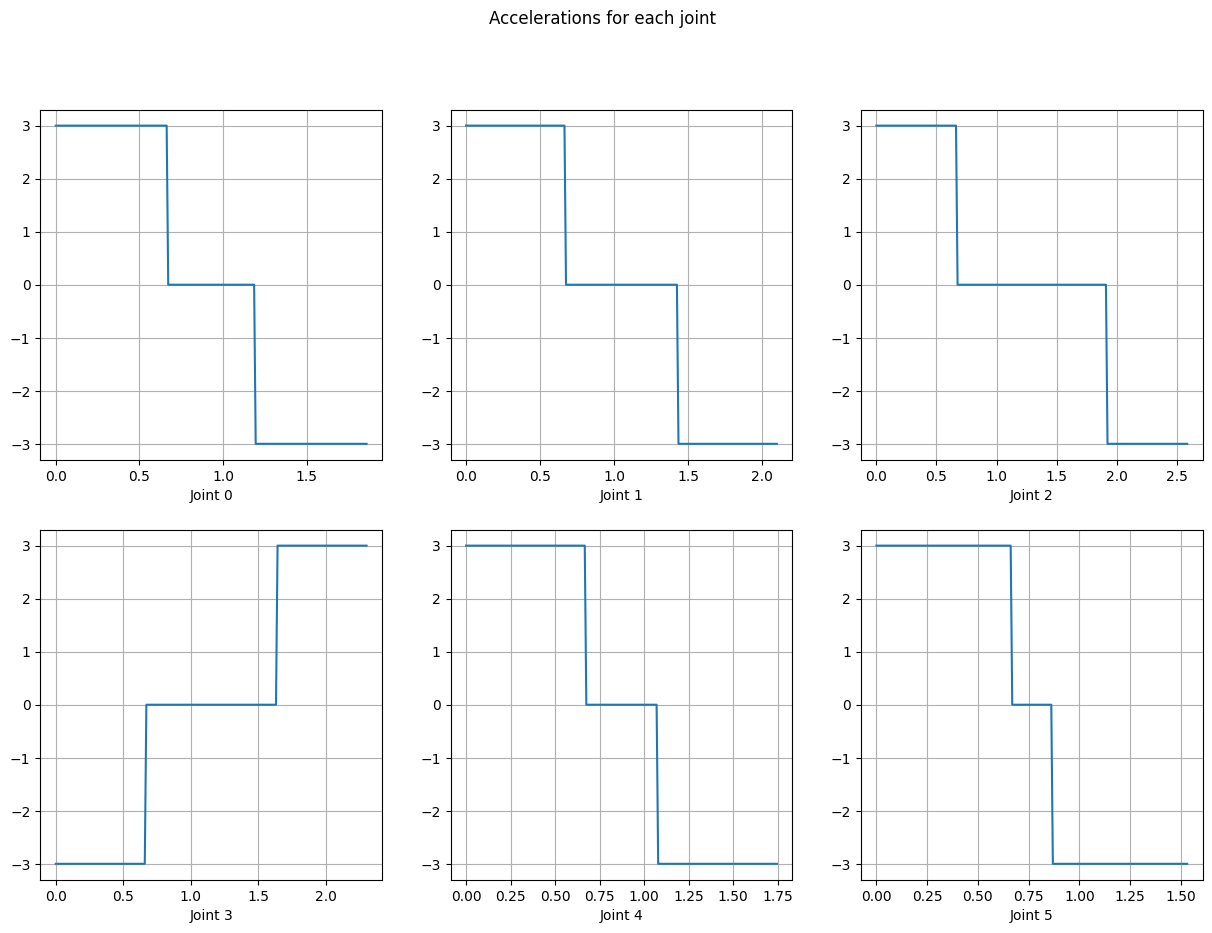

In [9]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Accelerations for each joint')

for i, (timeline, acceleration) in enumerate(zip(timelines, accelerations)):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 2

Synchronize your 6 joints to start and end motion at the same time.

In [10]:
# calculating maximum blend and non-acceleration times

blend_time = constraints.velocity / constraints.acceleration
acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

max_blend_time = None
max_non_acceleration_time = None

for initial, final in zip(initial_position, final_position):
    delta_distance = abs(final - initial)

    blend_time = constraints.velocity / constraints.acceleration
    acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

    non_acceleration_distance = delta_distance - acceleration_distance
    non_acceleration_time = non_acceleration_distance / constraints.velocity

    if non_acceleration_time < 0:
        blend_time = np.sqrt(abs(final - initial) / constraints.acceleration)
        non_acceleration_time = 0

    if max_blend_time is None or max_blend_time < blend_time:
        max_blend_time = blend_time
    if max_non_acceleration_time is None or max_non_acceleration_time < non_acceleration_time:
        max_non_acceleration_time = non_acceleration_time

In [11]:
# calculating synchronized velocities and accelerations

delta_distances = [final - initial for initial, final in zip(initial_position, final_position)]

synchronized_velocities = [delta / (max_non_acceleration_time + max_blend_time) for delta in delta_distances]
synchronized_accelerations = [velocity / max_blend_time for velocity in synchronized_velocities]

In [12]:
def triangular_synchronized(initial_value: float, blend_time: float, acceleration: float):
    timeline = np.linspace(0, blend_time * 2, 200)

    first_stage_distance = initial_value + acceleration * blend_time ** 2 / 2

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: initial_value + acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + acceleration * blend_time * t - acceleration * t ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: acceleration * t,
                  lambda t: acceleration * blend_time - acceleration * t]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: acceleration,
                  lambda t: -acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [13]:
def trapezoidal_synchronized(initial_value: float, blend_time: float, non_acceleration_time: float, velocity: float, acceleration: float):
    timeline = np.linspace(0, blend_time * 2 + non_acceleration_time, 200)

    first_stage_distance = initial_value + acceleration * blend_time ** 2 / 2
    second_stage_distance = first_stage_distance + velocity * non_acceleration_time

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: initial_value + acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + velocity * (t - blend_time),
                  lambda t: second_stage_distance + velocity * (t - blend_time - non_acceleration_time) - acceleration * (t - blend_time - non_acceleration_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: acceleration * t,
                  lambda t: velocity,
                  lambda t: velocity - acceleration * (t - blend_time - non_acceleration_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: acceleration,
                  lambda t: 0,
                  lambda t: -acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [14]:
# calculating synchronized trajectories

trajectories = []
velocities = []
accelerations = []
timelines = []

for initial, final, velocity, acceleration in zip(initial_position, final_position, synchronized_velocities, synchronized_accelerations):
    delta_distance = abs(final - initial)

    acceleration_distance = velocity ** 2 / acceleration
    non_acceleration_distance = delta_distance - acceleration_distance

    if non_acceleration_distance < 0:
        timeline, trajectory, velocity, acceleration = triangular_synchronized(initial, max_blend_time, acceleration)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_synchronized(initial, max_blend_time, max_non_acceleration_time, velocity, acceleration)
    timelines.append(timeline)
    trajectories.append(trajectory)
    velocities.append(velocity)
    accelerations.append(acceleration)

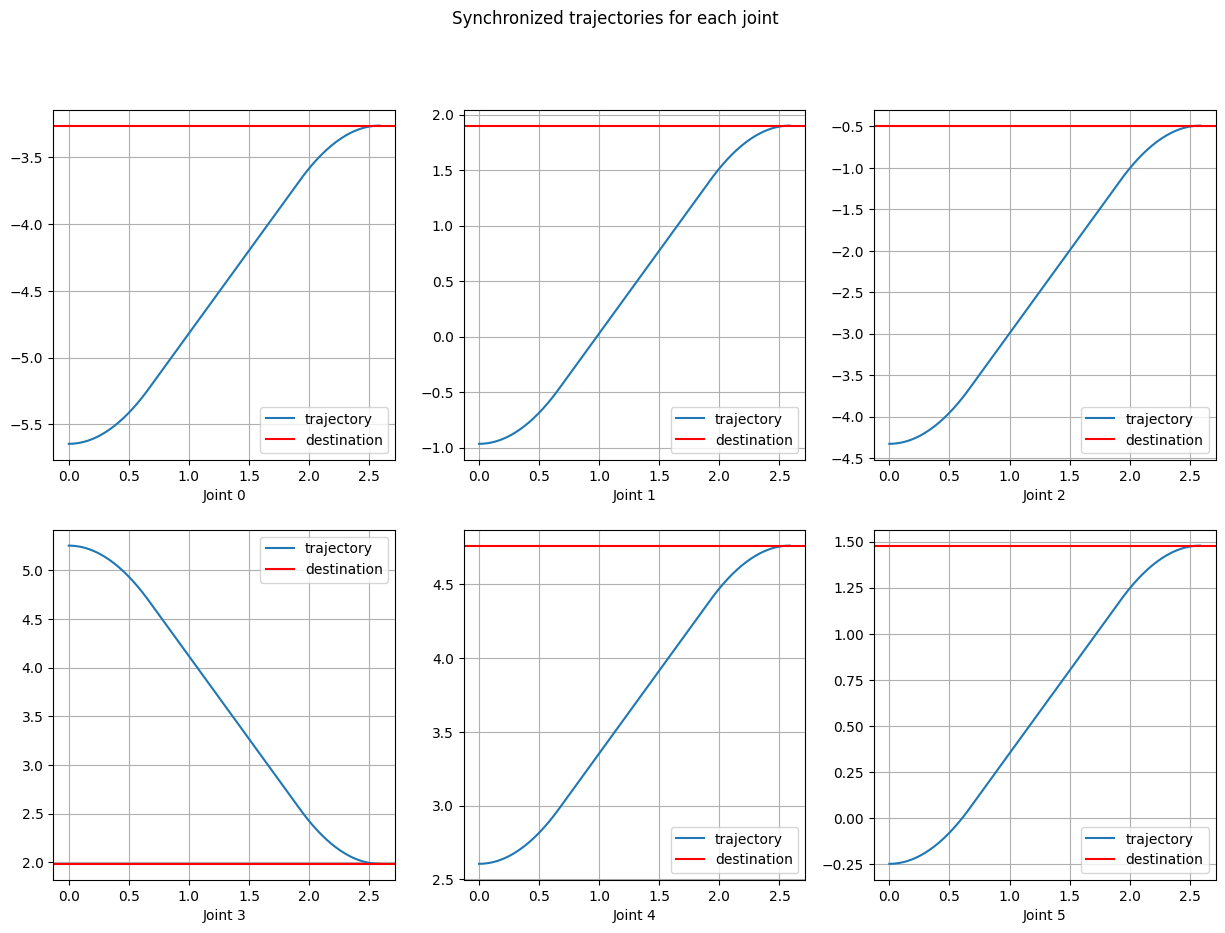

In [15]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized trajectories for each joint')

for i, (timeline, trajectory, destination) in enumerate(zip(timelines, trajectories, final_position)):
    axes[i // 3, i % 3].plot(timeline, trajectory, label='trajectory')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    axes[i // 3, i % 3].axhline(destination, label='destination', color='r')
    axes[i // 3, i % 3].legend()

plt.show()

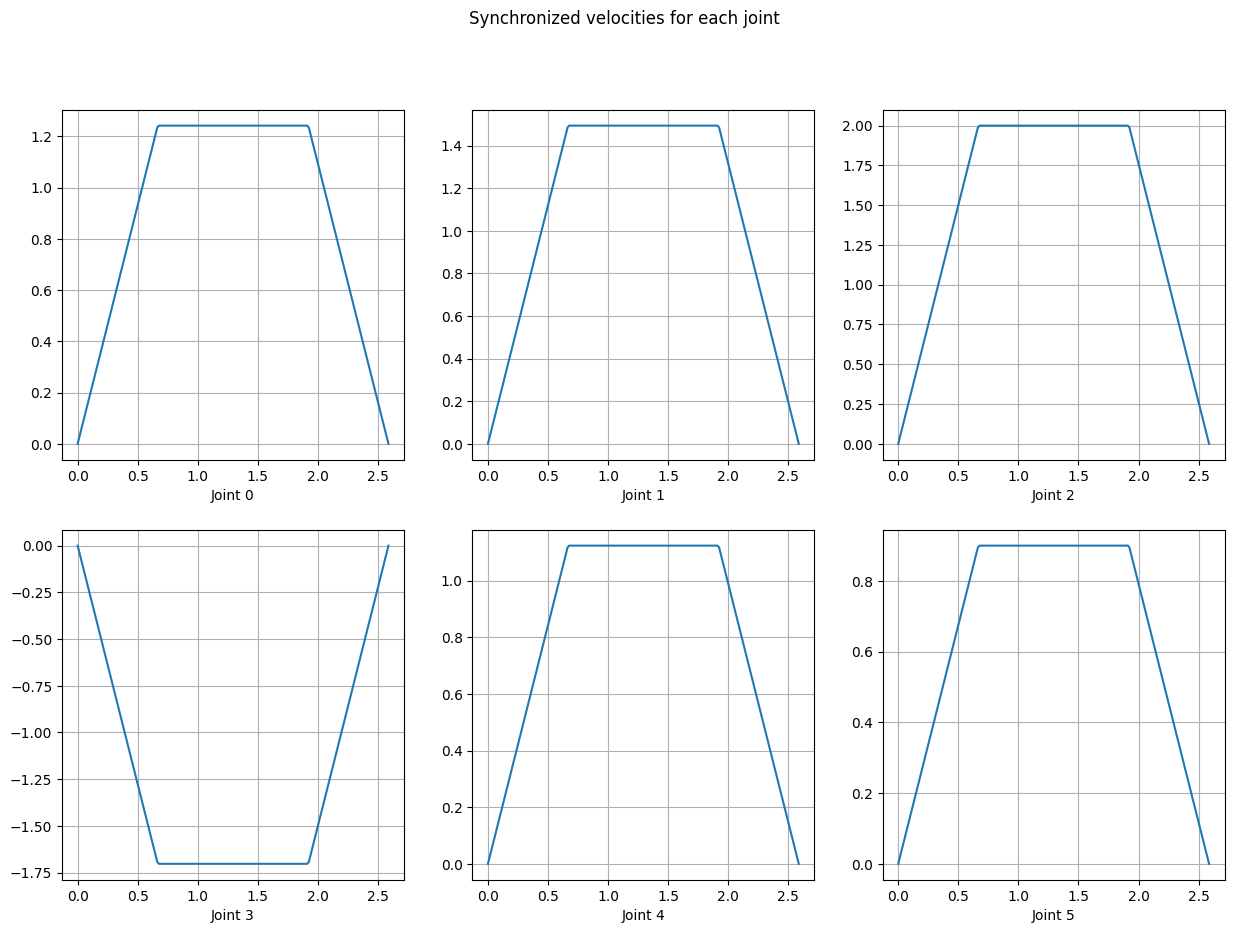

In [16]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized velocities for each joint')

for i, (timeline, velocity) in enumerate(zip(timelines, velocities)):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

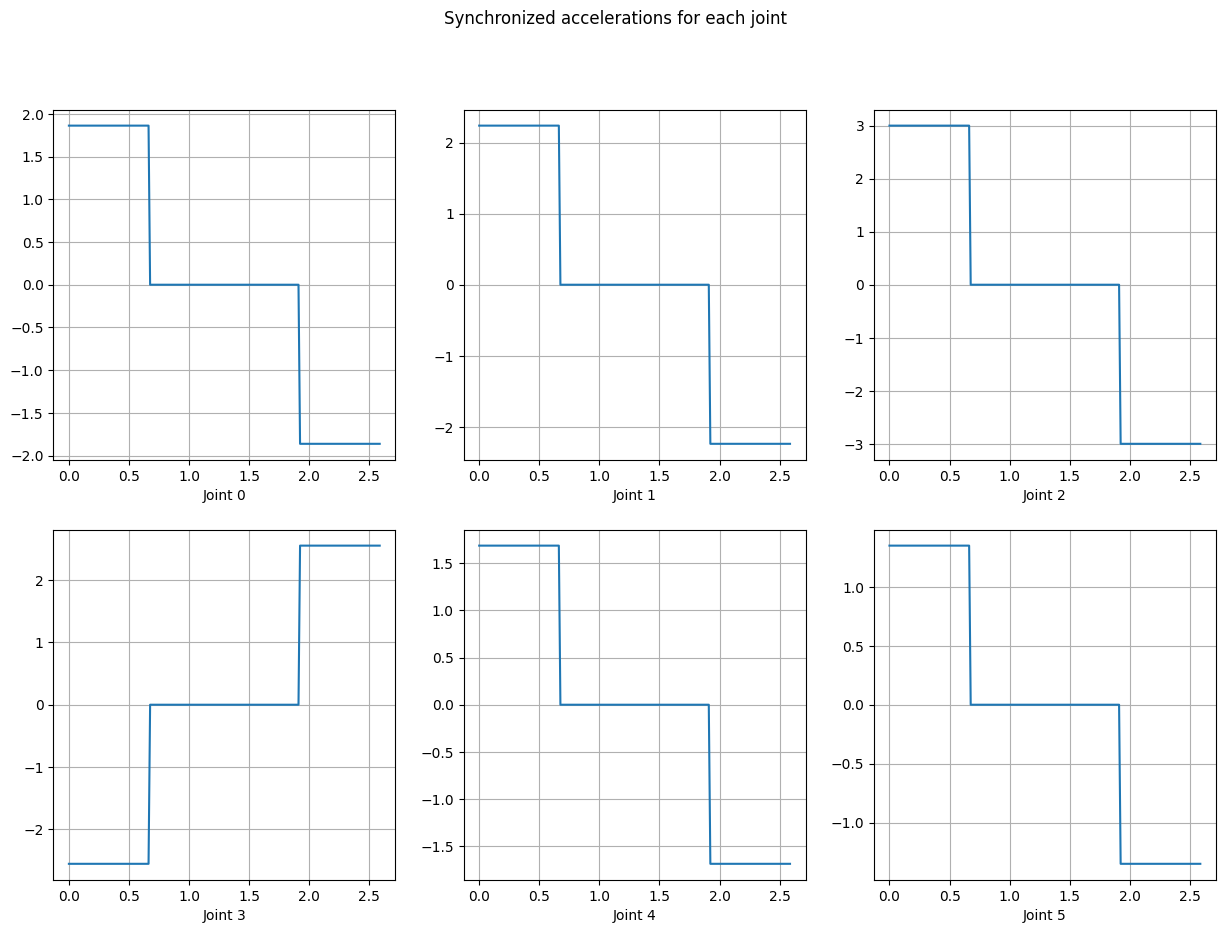

In [17]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized accelerations for each joint')

for i, (timeline, acceleration) in enumerate(zip(timelines, accelerations)):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 3

Consider you have controller frequency of 20Hz.

In [18]:
from math import ceil

In [19]:
def triangular_with_frequency(initial_value: float, blend_time: float, acceleration: float, frequency: float):
    timeline = np.linspace(0, blend_time * 2, 200)

    blend_time_frequency = ceil(blend_time * frequency) / frequency # find the closest moment of time according to the frequency

    first_stage_distance = initial_value + acceleration * blend_time_frequency ** 2 / 2

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time_frequency,
                  timeline > blend_time_frequency],
        funclist=[lambda t: initial_value + acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + acceleration * blend_time_frequency * t - acceleration * t ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time_frequency,
                  timeline > blend_time_frequency],
        funclist=[lambda t: acceleration * t,
                  lambda t: acceleration * blend_time_frequency - acceleration * t]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time_frequency,
                  timeline > blend_time_frequency],
        funclist=[lambda t: acceleration,
                  lambda t: -acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points


In [20]:
def trapezoidal_with_frequency(initial_value: float, blend_time: float, non_acceleration_time: float, velocity: float, acceleration: float, frequency: float):
    timeline = np.linspace(0, blend_time * 2 + non_acceleration_time, 200)

    blend_time_frequency = ceil(blend_time * frequency) / frequency
    non_acceleration_time_frequency = ceil(non_acceleration_time * frequency) / frequency
    blend_non_acceleration_time_frequency = blend_time_frequency + non_acceleration_time_frequency

    first_stage_distance = initial_value + acceleration * blend_time_frequency ** 2 / 2
    second_stage_distance = first_stage_distance + velocity * non_acceleration_time_frequency

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time_frequency,
                  np.logical_and(blend_time_frequency < timeline, timeline <= blend_non_acceleration_time_frequency),
                  blend_non_acceleration_time_frequency < timeline],
        funclist=[lambda t: initial_value + acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + velocity * (t - blend_time_frequency),
                  lambda t: second_stage_distance + velocity * (t - blend_non_acceleration_time_frequency) - acceleration * (t - blend_non_acceleration_time_frequency) ** 2 / 2]
    )
    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time_frequency,
                  np.logical_and(blend_time_frequency < timeline, timeline <= blend_non_acceleration_time_frequency),
                  blend_non_acceleration_time_frequency < timeline],
        funclist=[lambda t: acceleration * t,
                  lambda t: acceleration * blend_time_frequency,
                  lambda t: acceleration * blend_time_frequency - acceleration * (t - blend_non_acceleration_time_frequency)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time_frequency,
                  np.logical_and(blend_time_frequency < timeline, timeline <= blend_non_acceleration_time_frequency),
                  blend_non_acceleration_time_frequency < timeline],
        funclist=[lambda t: acceleration,
                  lambda t: 0,
                  lambda t: -acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [21]:
given_frequency = 20    # actually, it is too big frequency to see the difference, it can be seen better by setting the value less than 5

trajectories_frequency = []
velocities_frequency = []
accelerations_frequency = []
timelines_frequency = []

for initial, final, velocity, acceleration in zip(initial_position, final_position, synchronized_velocities, synchronized_accelerations):
    delta_distance = abs(final - initial)

    acceleration_distance = velocity ** 2 / acceleration
    non_acceleration_distance = delta_distance - acceleration_distance

    if non_acceleration_distance < 0:
        timeline, trajectory, velocity, acceleration = triangular_with_frequency(initial, max_blend_time, acceleration, given_frequency)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_with_frequency(initial, max_blend_time, max_non_acceleration_time, velocity, acceleration, given_frequency)
    timelines_frequency.append(timeline)
    trajectories_frequency.append(trajectory)
    velocities_frequency.append(velocity)
    accelerations_frequency.append(acceleration)

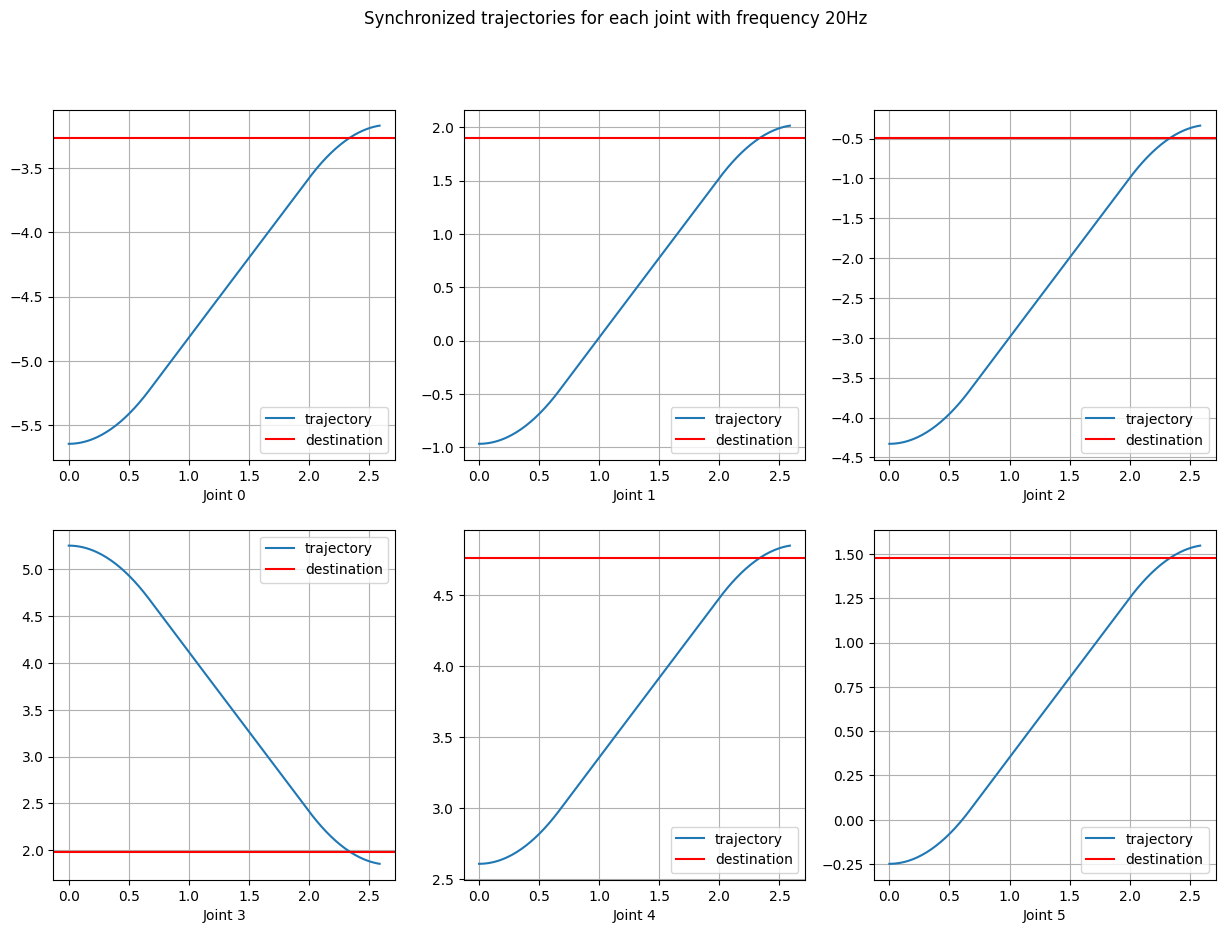

In [22]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized trajectories for each joint with frequency 20Hz')

for i, (timeline, trajectory, destination) in enumerate(zip(timelines_frequency, trajectories_frequency, final_position)):
    axes[i // 3, i % 3].plot(timeline, trajectory, label='trajectory')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    axes[i // 3, i % 3].axhline(destination, label='destination', color='r')
    axes[i // 3, i % 3].legend()

plt.show()

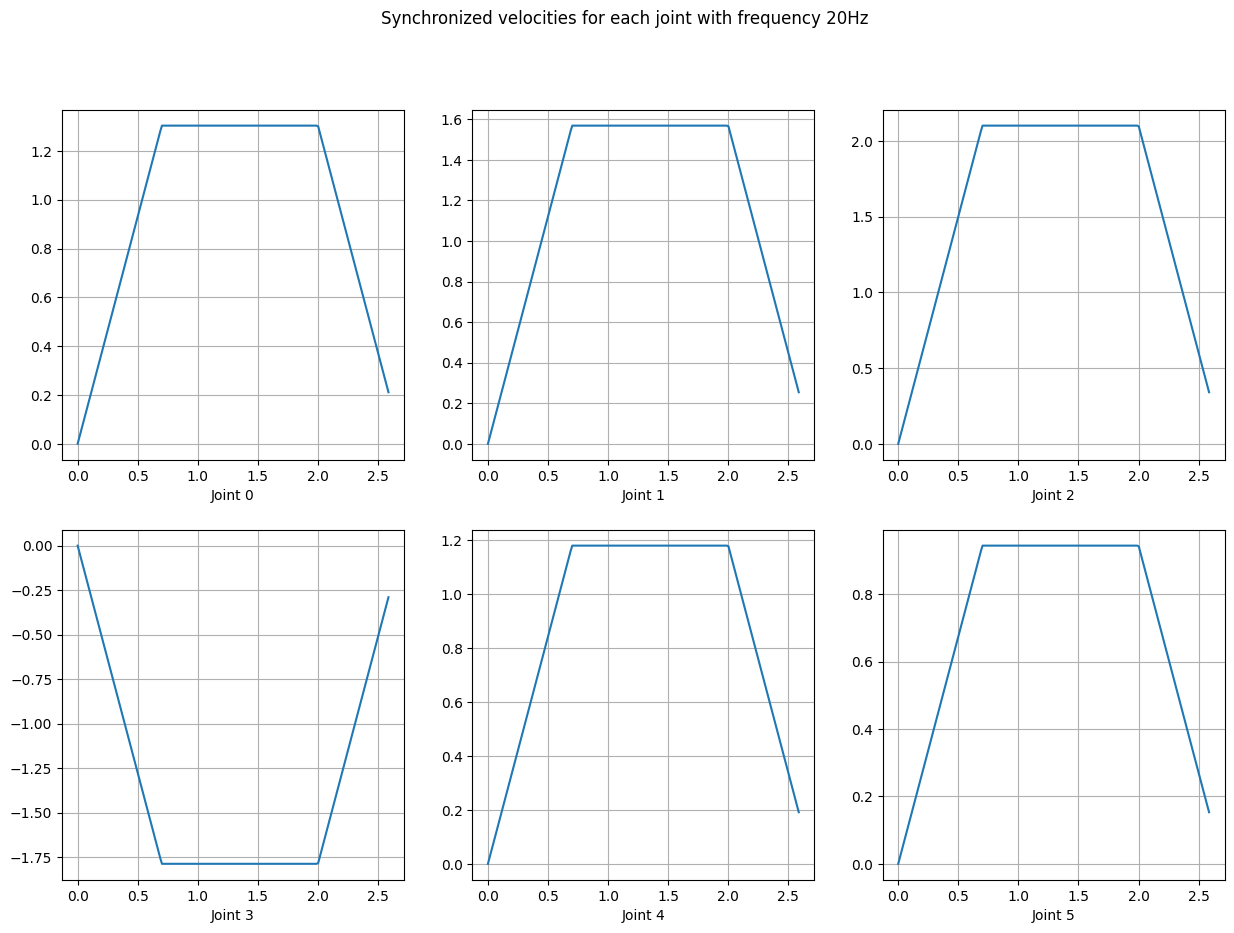

In [23]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized velocities for each joint with frequency 20Hz')

for i, (timeline, velocity) in enumerate(zip(timelines_frequency, velocities_frequency)):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

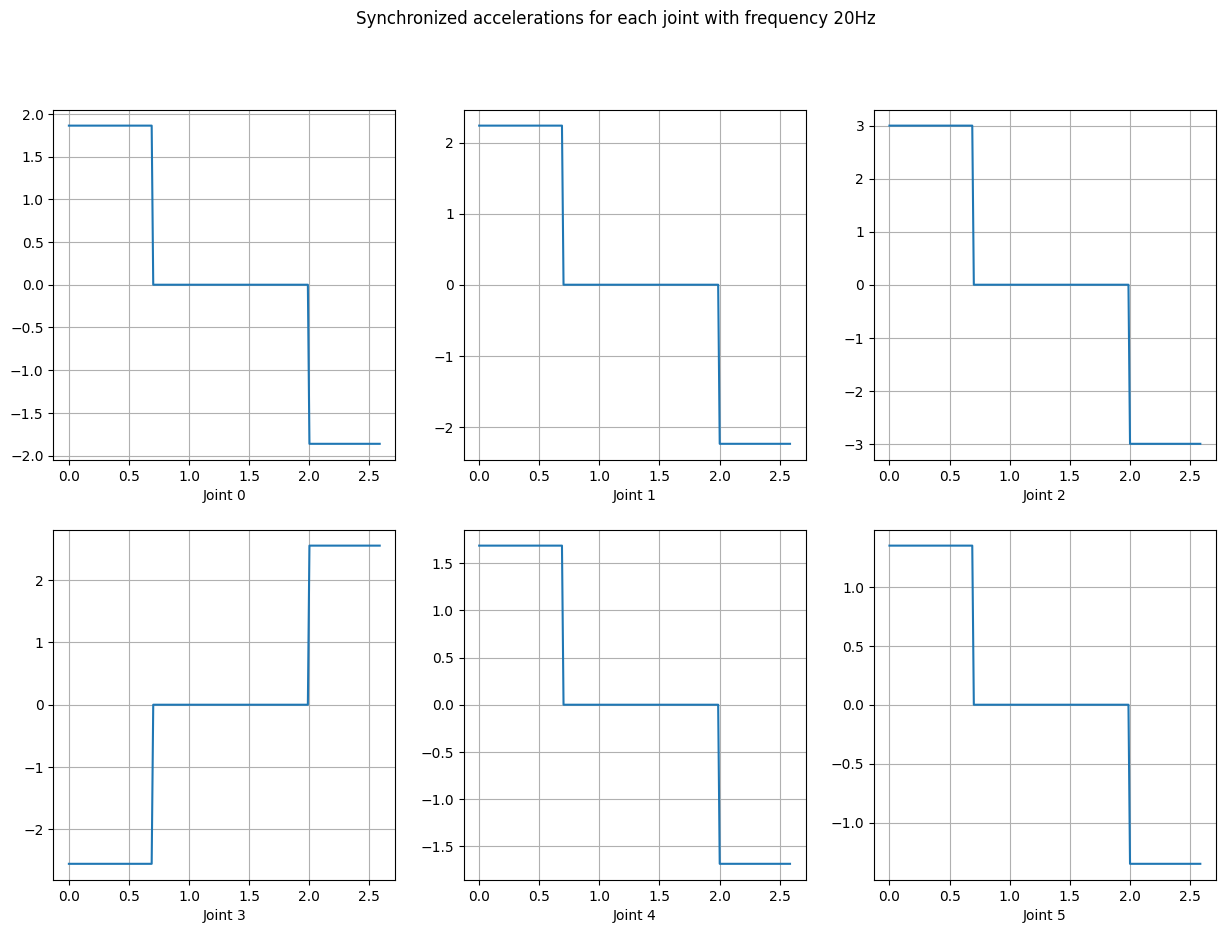

In [24]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized accelerations for each joint with frequency 20Hz')

for i, (timeline, acceleration) in enumerate(zip(timelines_frequency, accelerations_frequency)):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 4

Calculate propagated error in end-effector position.

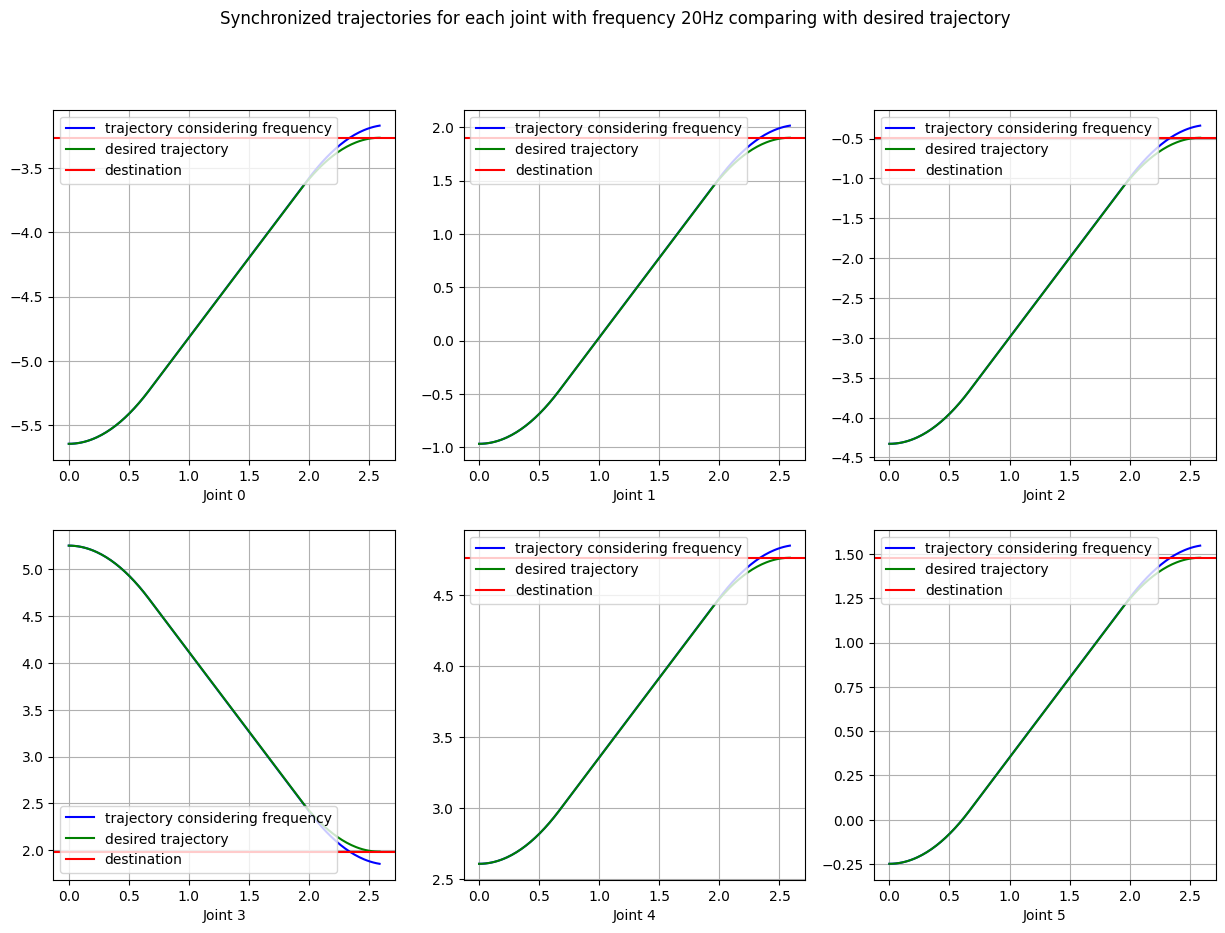

In [25]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized trajectories for each joint with frequency 20Hz comparing with desired trajectory')

for i, (timeline, trajectory, destination, timeline_true, trajectory_true) in enumerate(zip(timelines_frequency, trajectories_frequency, final_position, timelines, trajectories)):
    axes[i // 3, i % 3].plot(timeline, trajectory, label='trajectory considering frequency', color='b')
    axes[i // 3, i % 3].plot(timeline_true, trajectory_true, label='desired trajectory', color='g')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    axes[i // 3, i % 3].axhline(destination, label='destination', color='r')
    axes[i // 3, i % 3].legend()

plt.show()

In [26]:
errors = [np.abs(actual - true) for actual, true in zip(trajectories, trajectories_frequency)]

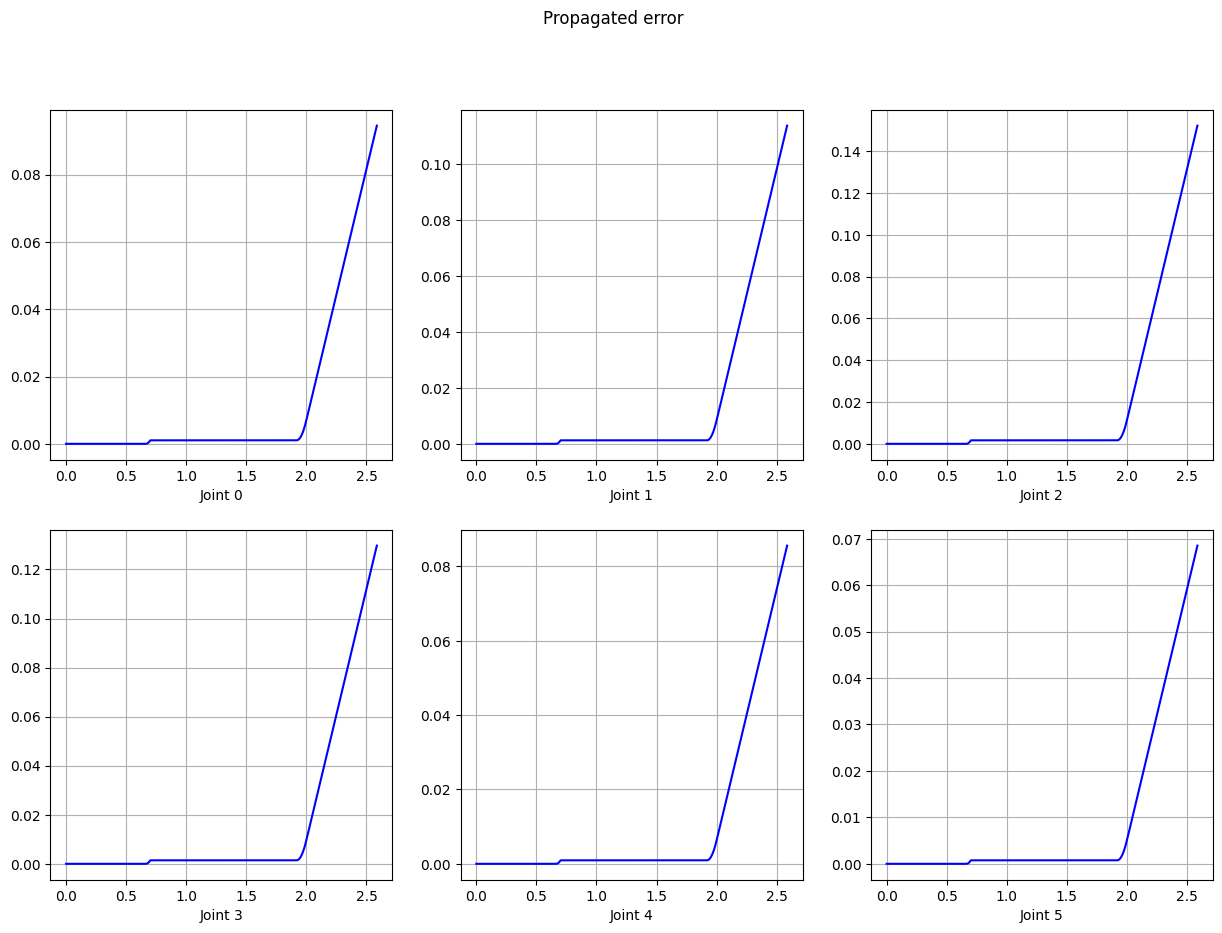

In [27]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Propagated error')

for i, (timeline, error) in enumerate(zip(timelines, errors)):
    axes[i // 3, i % 3].plot(timeline, error, color='b')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 5

Redefine synchronized trajectories for numerical control.

In [28]:
# synchronize again but now to satisfy numerical control

delta_distances = [final - initial for initial, final in zip(initial_position, final_position)]

blend_time_frequency = ceil(max_blend_time * given_frequency) / given_frequency
non_acceleration_time_frequency = ceil(max_non_acceleration_time * given_frequency) / given_frequency

synchronized_velocities = [delta / (non_acceleration_time_frequency + blend_time_frequency) for delta in delta_distances]
synchronized_accelerations = [velocity / blend_time_frequency for velocity in synchronized_velocities]

In [29]:
trajectories_fixed = []
velocities_fixed = []
accelerations_fixed = []
timelines_fixed = []

for initial, final, velocity, acceleration in zip(initial_position, final_position, synchronized_velocities, synchronized_accelerations):
    delta_distance = abs(final - initial)

    acceleration_distance = velocity ** 2 / acceleration
    non_acceleration_distance = delta_distance - acceleration_distance

    if non_acceleration_distance < 0:
        timeline, trajectory, velocity, acceleration = triangular_with_frequency(initial, blend_time_frequency, acceleration, given_frequency)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_with_frequency(initial, blend_time_frequency, non_acceleration_time_frequency, velocity, acceleration, given_frequency)
    timelines_fixed.append(timeline)
    trajectories_fixed.append(trajectory)
    velocities_fixed.append(velocity)
    accelerations_fixed.append(acceleration)

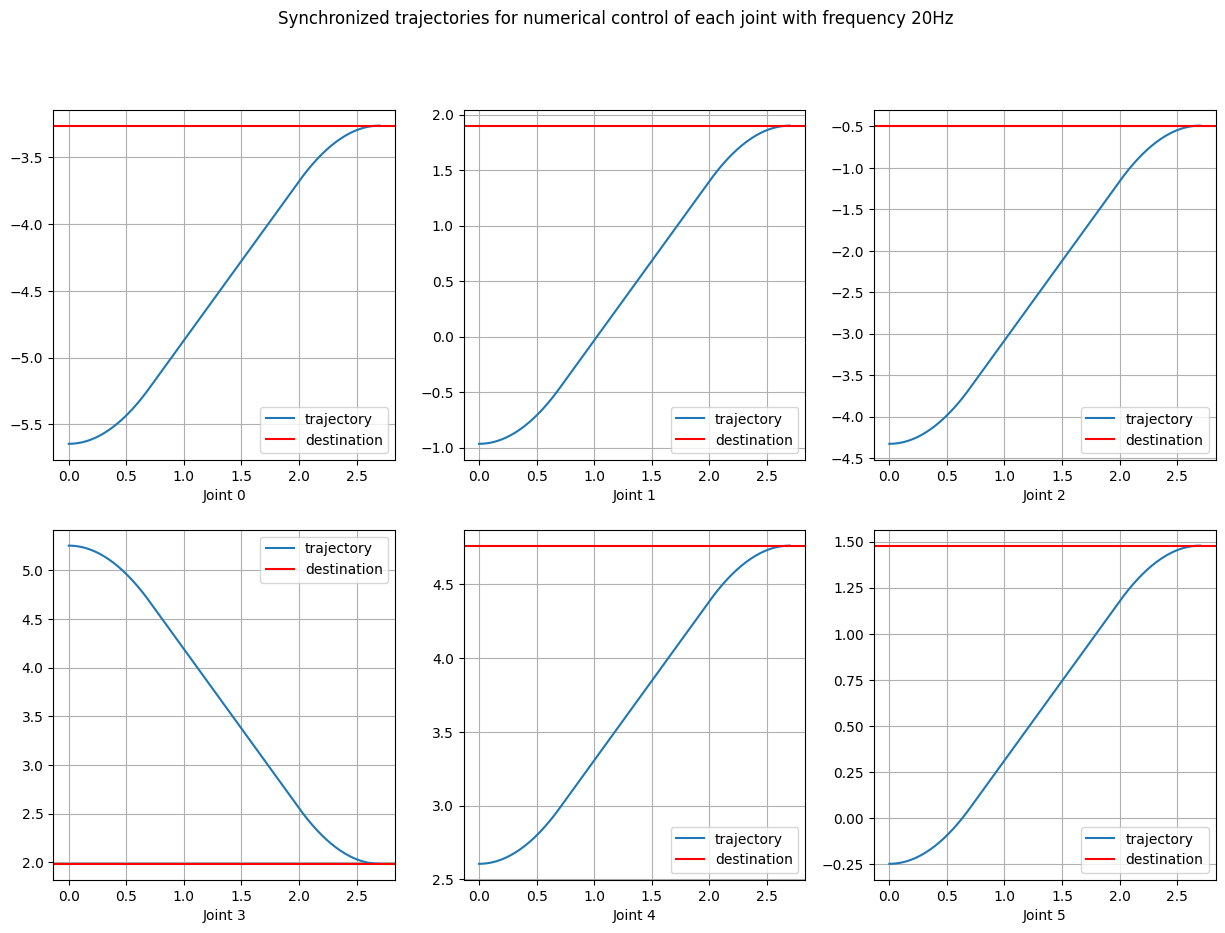

In [30]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized trajectories for numerical control of each joint with frequency 20Hz')

for i, (timeline, trajectory, destination) in enumerate(zip(timelines_fixed, trajectories_fixed, final_position)):
    axes[i // 3, i % 3].plot(timeline, trajectory, label='trajectory')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    axes[i // 3, i % 3].axhline(destination, label='destination', color='r')
    axes[i // 3, i % 3].legend()

plt.show()

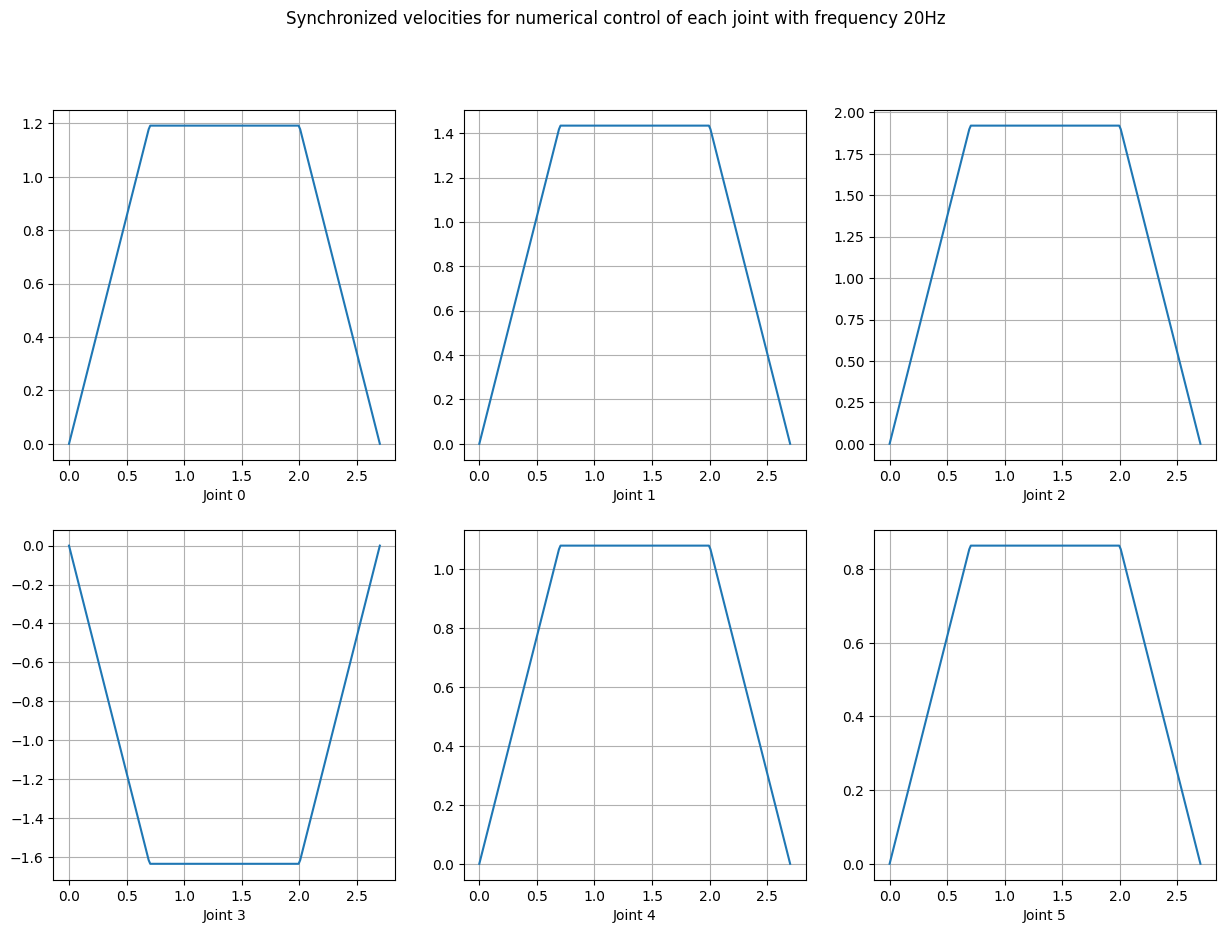

In [31]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized velocities for numerical control of each joint with frequency 20Hz')

for i, (timeline, velocity) in enumerate(zip(timelines_fixed, velocities_fixed)):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

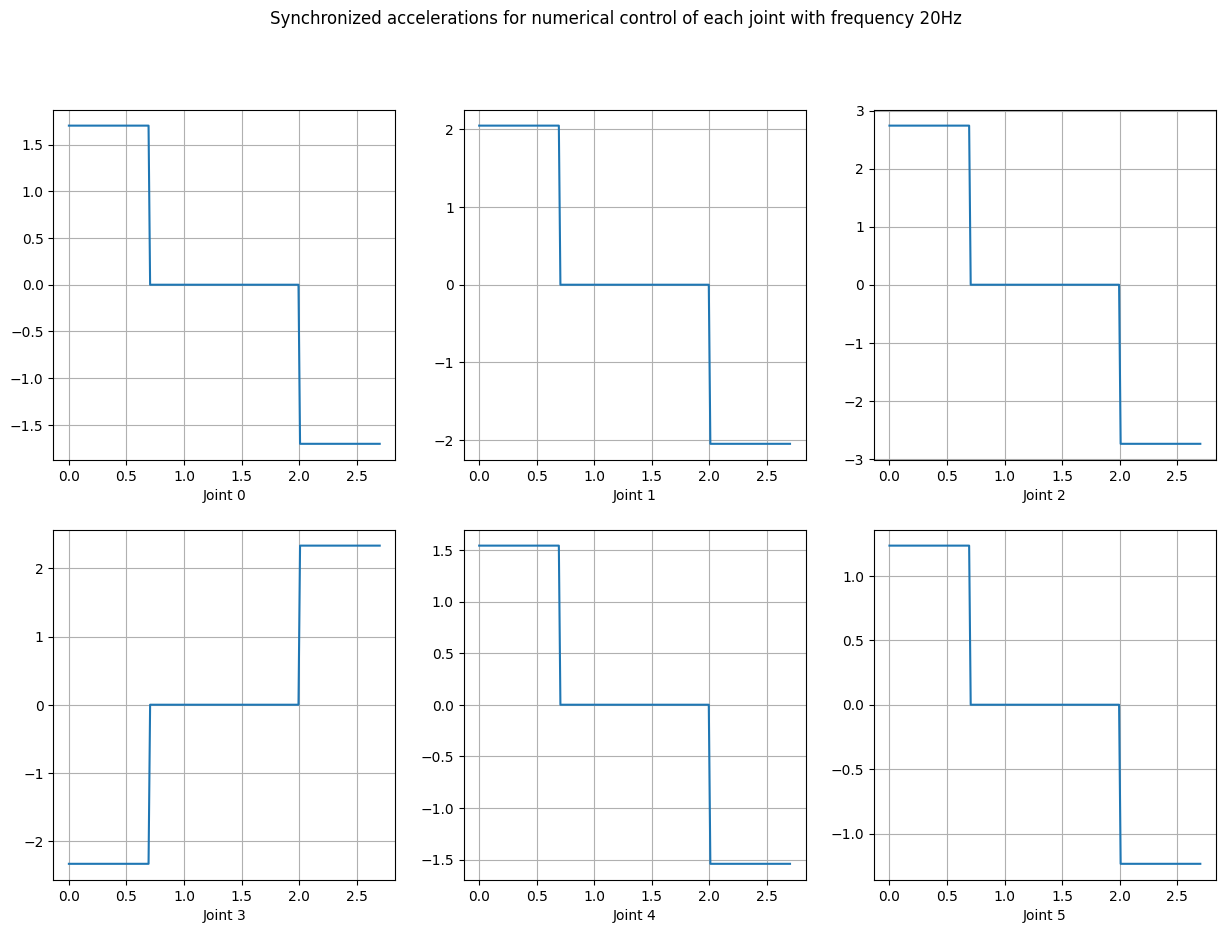

In [32]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Synchronized accelerations for numerical control of each joint with frequency 20Hz')

for i, (timeline, acceleration) in enumerate(zip(timelines_fixed, accelerations_fixed)):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 6

Drive your robot model between 2 consequent points. (Solve polynomial)

In [33]:
Conditions = namedtuple('Conditions', ['time', 'position', 'velocity', 'acceleration'])

In [34]:
def construct_quintic_polynom_matrix(initial_time: float, final_time: float) -> np.ndarray:
    t_0, t_f = initial_time, final_time
    return np.array([[t_0 ** 5,         t_0 ** 4,       t_0 ** 3,       t_0 ** 2,   t_0,    1],
                     [t_f ** 5,         t_f ** 4,       t_f ** 3,       t_f ** 2,   t_f,    1],
                     [5 * t_0 ** 4,     4 * t_0 ** 3,   3 * t_0 ** 2,   2 * t_0,    1,      0],
                     [5 * t_f ** 4,     4 * t_f ** 3,   3 * t_f ** 2,   2 * t_f,    1,      0],
                     [20 * t_0 ** 3,    12 * t_0 ** 2,  6 * t_0,        2,          0,      0],
                     [20 * t_f ** 3,    12 * t_f ** 2,  6 * t_f,        2,          0,      0]])

In [35]:
from itertools import chain


def find_polynom_coefficients(initial_conditions: Conditions, final_conditions: Conditions) -> np.ndarray:
    matrix = construct_quintic_polynom_matrix(initial_conditions.time, final_conditions.time)
    column = np.array(list(chain.from_iterable([[x for x in initial_final] for initial_final in zip(initial_conditions[1:], final_conditions[1:])])))

    return np.linalg.solve(matrix, column)


In [36]:
def get_position(coefficients: np.ndarray, time: float) -> float:
    time_vector = np.array([time ** (5 - i) for i in range(6)])
    return coefficients.dot(time_vector)


def get_velocity(coefficients: np.ndarray, time: float) -> float:
    time_vector = np.array([5 * time ** 4, 4 * time ** 3, 3 * time ** 2, 2 * time, 1, 0])
    return coefficients.dot(time_vector)


def get_acceleration(coefficients: np.ndarray, time: float) -> float:
    time_vector = np.array([20 * time ** 3, 12 * time ** 2, 6 * time, 2, 0, 0])
    return coefficients.dot(time_vector)

In [37]:
initial_states = [Conditions(0, *[uniform(0, 10) for _ in range(3)]) for _ in range(6)]
final_states = [Conditions(10, *[uniform(0, 10) for _ in range(3)]) for _ in range(6)]

coefficients_list = [find_polynom_coefficients(initial_state, final_state) for initial_state, final_state in zip(initial_states, final_states)]

In [38]:
timeline = np.linspace(0, 10, 200)

positions = []
velocities = []
accelerations = []

for coefficients in coefficients_list:
    positions.append(np.array([get_position(coefficients, t) for t in timeline]))
    velocities.append(np.array([get_velocity(coefficients, t) for t in timeline]))
    accelerations.append(np.array([get_acceleration(coefficients, t) for t in timeline]))

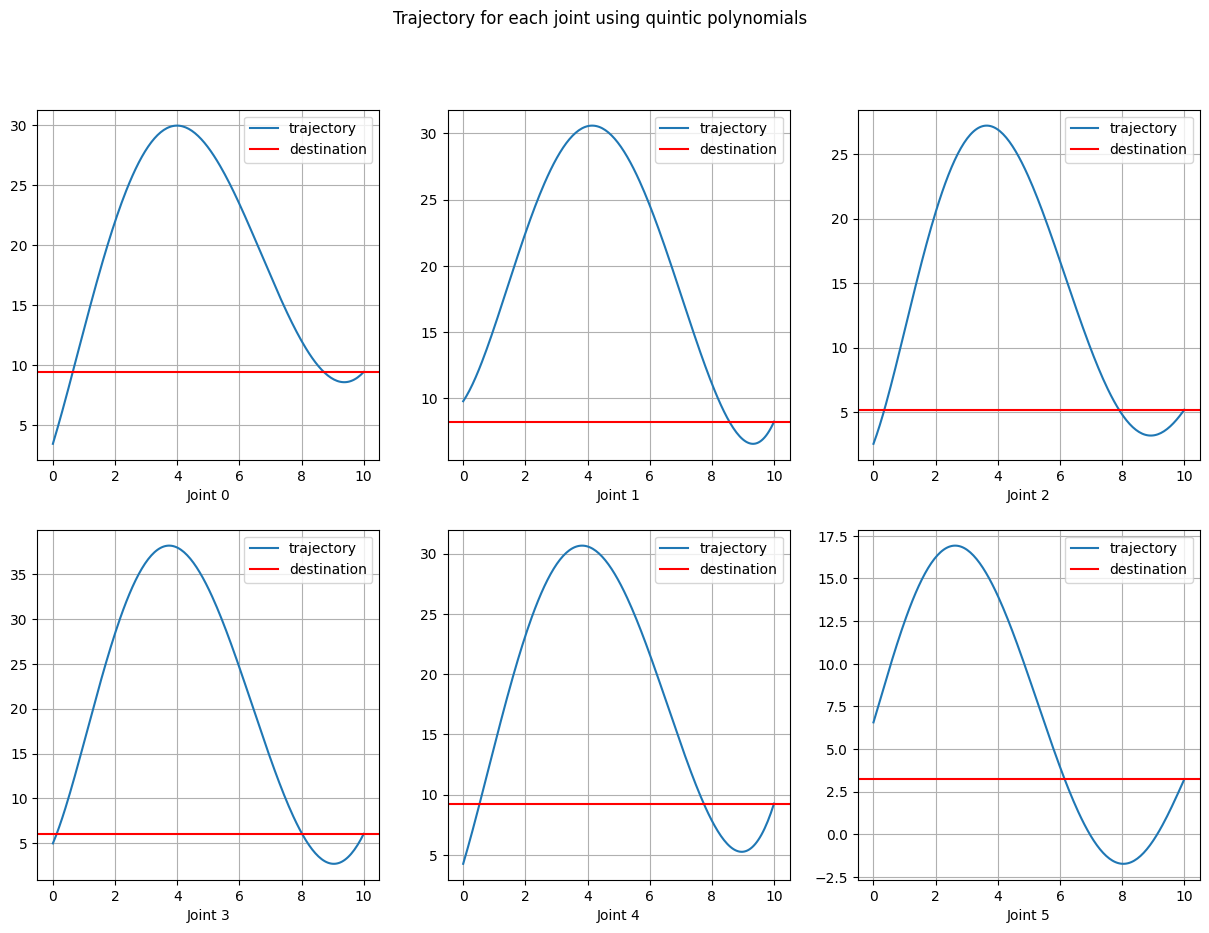

In [39]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Trajectory for each joint using quintic polynomials')

for i, (position, destination) in enumerate(zip(positions, final_states)):
    axes[i // 3, i % 3].plot(timeline, position, label='trajectory')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    axes[i // 3, i % 3].axhline(destination.position, label='destination', color='r')
    axes[i // 3, i % 3].legend()

plt.show()

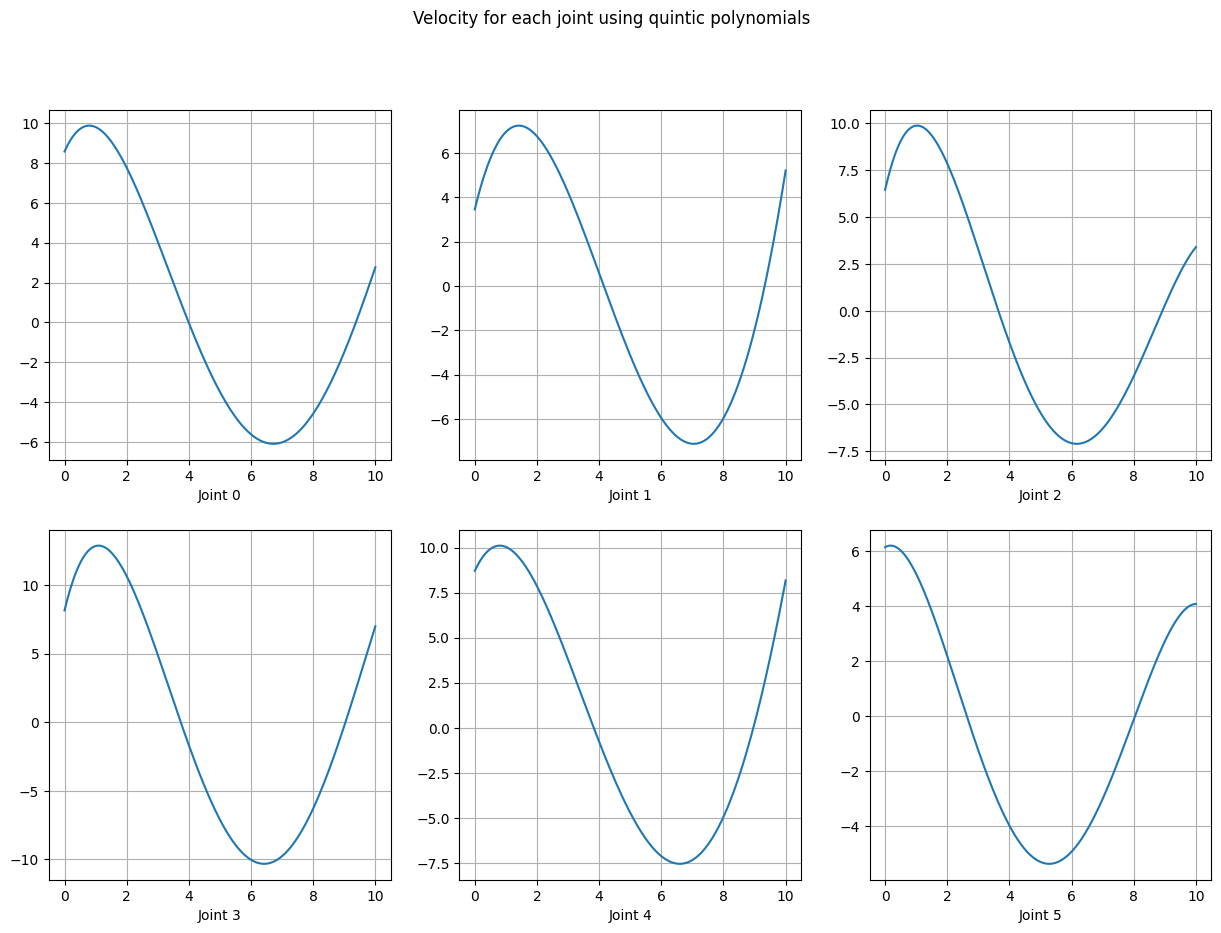

In [40]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Velocity for each joint using quintic polynomials')

for i, velocity in enumerate(velocities):
    axes[i // 3, i % 3].plot(timeline, velocity)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

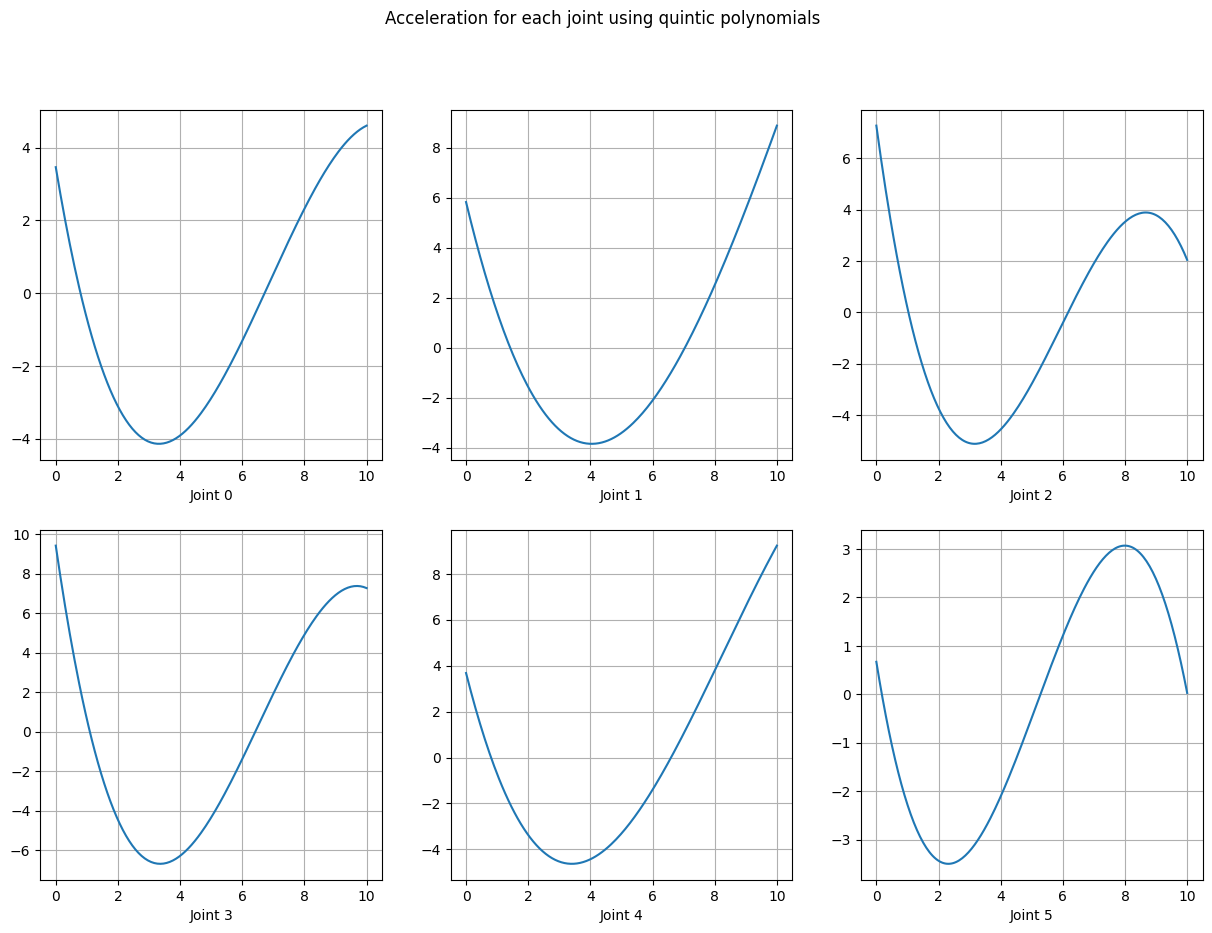

In [41]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Acceleration for each joint using quintic polynomials')

for i, acceleration in enumerate(accelerations):
    axes[i // 3, i % 3].plot(timeline, acceleration)
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')

plt.show()

# Task 7

Solve polynomial constraining null value for initial and final acceleration passing through 4 consequent points.

In [42]:
def get_random_states(time: float):
    return [Conditions(time, uniform(-10, 10), uniform(-10, 10), 0) for _ in range(6)]

In [43]:
time_per_segment = 5

states_list = [get_random_states(time_per_segment * i) for i in range(4)]

In [44]:
timeline = []
positions = []
velocities = []
accelerations = []

for i in range(1, len(states_list)):
    previous_states = states_list[i - 1]
    current_states = states_list[i]

    coefficients_list = [find_polynom_coefficients(previous_state, current_state) for previous_state, current_state in zip(previous_states, current_states)]

    current_timeline = np.linspace(previous_states[0].time, current_states[0].time, 200)
    current_positions = []
    current_velocities = []
    current_accelerations = []

    for coefficients in coefficients_list:
        current_positions.append([get_position(coefficients, t) for t in current_timeline])
        current_velocities.append([get_velocity(coefficients, t) for t in current_timeline])
        current_accelerations.append([get_acceleration(coefficients, t) for t in current_timeline])

    timeline.extend(current_timeline)
    if not positions:
        positions.extend(current_positions)
        velocities.extend(current_velocities)
        accelerations.extend(current_accelerations)
    else:
        for position, current_position in zip(positions, current_positions):
            position.extend(current_position)
        for velocity, current_velocity in zip(velocities, current_velocities):
            velocity.extend(current_velocity)
        for acceleration, current_acceleration in zip(accelerations, current_accelerations):
            acceleration.extend(current_acceleration)


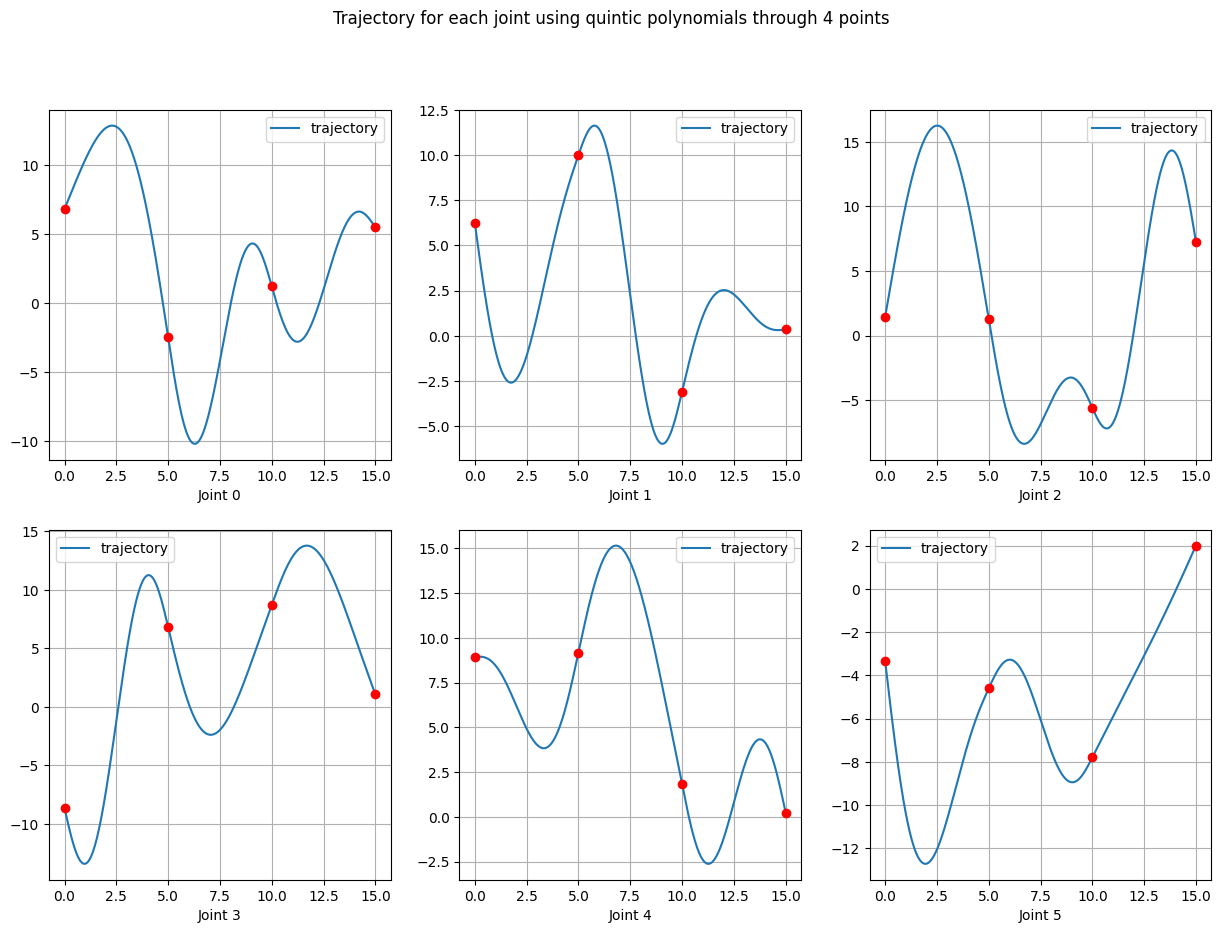

In [45]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Trajectory for each joint using quintic polynomials through 4 points')

for i, position in enumerate(positions):
    axes[i // 3, i % 3].plot(timeline, position, label='trajectory')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    for states in states_list:
        axes[i // 3, i % 3].plot(states[i].time, states[i].position, marker='o', color='red')
    axes[i // 3, i % 3].legend()

plt.show()

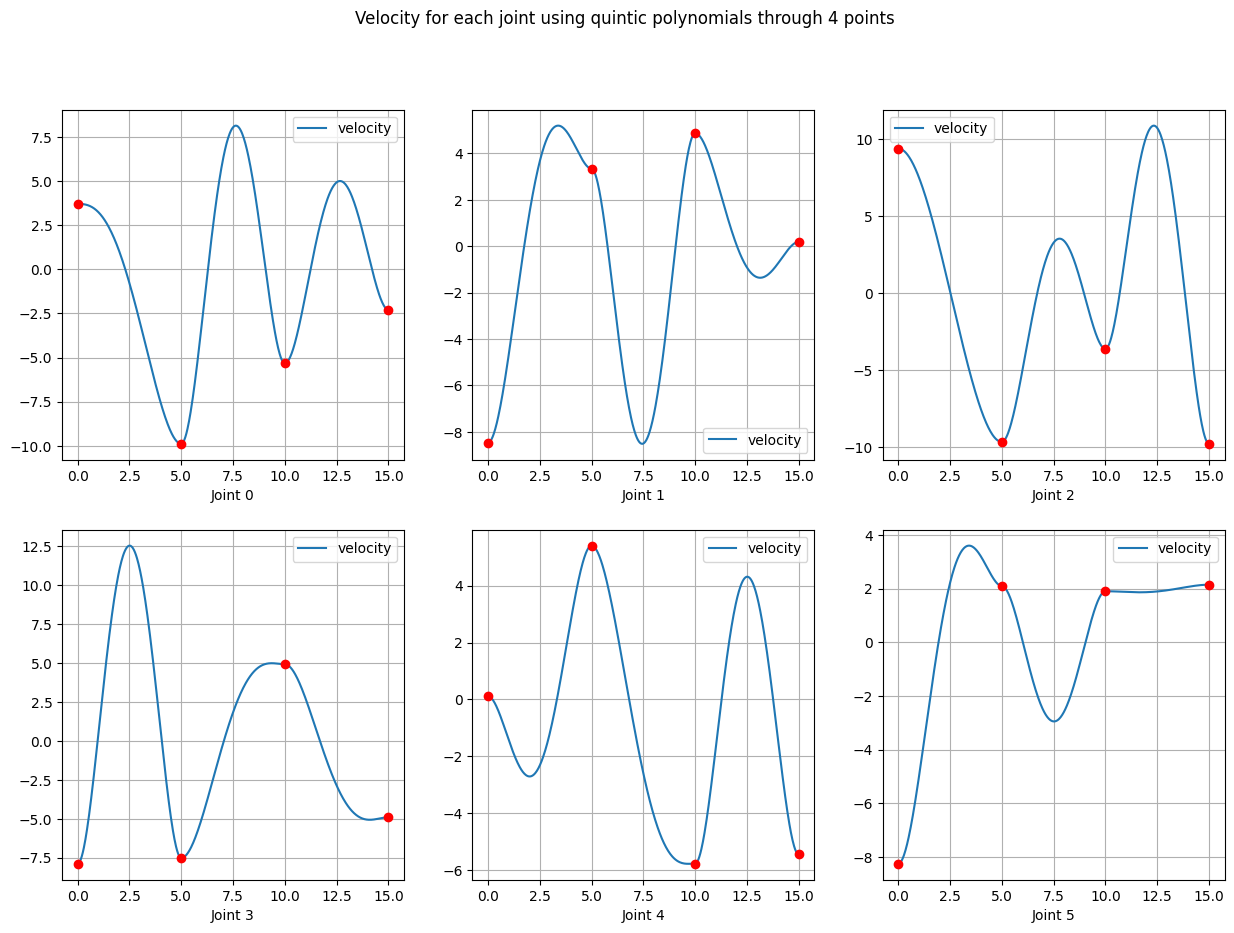

In [46]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Velocity for each joint using quintic polynomials through 4 points')

for i, velocity in enumerate(velocities):
    axes[i // 3, i % 3].plot(timeline, velocity, label='velocity')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    for states in states_list:
        axes[i // 3, i % 3].plot(states[i].time, states[i].velocity, marker='o', color='red')
    axes[i // 3, i % 3].legend()

plt.show()

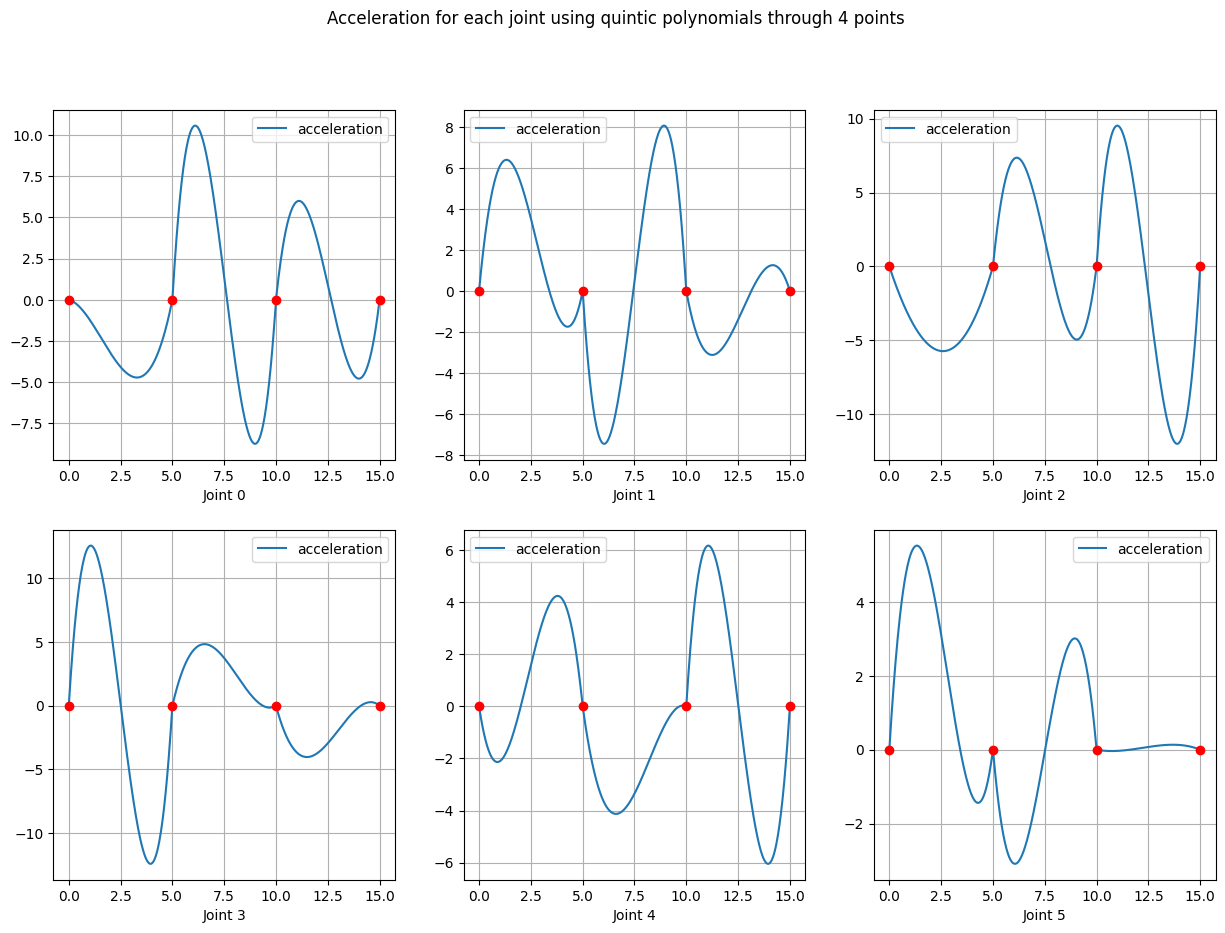

In [47]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
figure.suptitle('Acceleration for each joint using quintic polynomials through 4 points')

for i, acceleration in enumerate(accelerations):
    axes[i // 3, i % 3].plot(timeline, acceleration, label='acceleration')
    axes[i // 3, i % 3].grid(True)
    axes[i // 3, i % 3].set_xlabel(f'Joint {i}')
    for states in states_list:
        axes[i // 3, i % 3].plot(states[i].time, states[i].acceleration, marker='o', color='red')
    axes[i // 3, i % 3].legend()

plt.show()